#  Medical Insurance Charges Analysis

##  Objective

Analyze the key factors affecting **medical insurance charges** and build predictive models.

**Outcome:**
- Understand key factors affecting insurance charges
- Build predictive models and evaluate their performance
- Compare interpretable models with non-linear machine learning models

**Target variable:** `charges`

**Evaluation metrics:** RMSE, R²

## Import Libraries

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##  Load Dataset
Dataset: Medical Insurance Dataset

In [3]:
url = '/Users/ethanchen/Medical_Insurance/insurance.csv'
df = pd.read_csv(url)
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


m## Data Overview

### Missing Values Check

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Missing value inspection showed that the dataset contains no missing values

### Outliners Check

In [4]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


The results clearly show the presence of outliers, and therefore outlier removal is necessary

### Outlier Handling (IQR Method)
Apply the **IQR** method to:
- Reduce the impact of extreme outliers
- Improve linear model stability


In [6]:
def iqr_bounds(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper


df_iqr = df.copy()

cols = ['age', 'bmi', 'children', 'charges']

for col in cols:
    lower, upper = iqr_bounds(df[col])
    df_iqr = df_iqr[(df_iqr[col] >= lower) & (df_iqr[col] <= upper)]

Recheck outliers to ensure they have been successfully removed using the IQR method

In [45]:
print(df_iqr.describe())

               age          bmi     children       charges
count  1193.000000  1193.000000  1193.000000   1193.000000
mean     38.981559    29.998529     1.085499   9942.269682
std      14.063482     5.866873     1.216249   7251.326564
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    25.800000     0.000000   4415.158800
50%      39.000000    29.735000     1.000000   8410.046850
75%      51.000000    33.770000     2.000000  12979.358000
max      64.000000    46.750000     5.000000  34472.841000


## Feature Encoding
Categorical variables (`sex`, `smoker`, `region`) are encoded using **One-Hot Encoding**

In [8]:
df_encode = pd.get_dummies(
    df_iqr,
    columns=['sex', 'smoker', 'region'],
    drop_first=True,
    dtype='float64'
)

df_encode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1193 non-null   int64  
 1   bmi               1193 non-null   float64
 2   children          1193 non-null   int64  
 3   charges           1193 non-null   float64
 4   sex_male          1193 non-null   float64
 5   smoker_yes        1193 non-null   float64
 6   region_northwest  1193 non-null   float64
 7   region_southeast  1193 non-null   float64
 8   region_southwest  1193 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 93.2 KB


## Correlation Analysis
Analyze correlations between features to:
- Identify important predictors
- Detect linear relationships


In [9]:
corr_matrix = df_encode.corr()
print(corr_matrix)

                       age       bmi  children   charges  sex_male  \
age               1.000000  0.122592  0.039967  0.436815 -0.021146   
bmi               0.122592  1.000000  0.006796 -0.061033  0.016431   
children          0.039967  0.006796  1.000000  0.083093  0.015504   
charges           0.436815 -0.061033  0.083093  1.000000 -0.022511   
sex_male         -0.021146  0.016431  0.015504 -0.022511  1.000000   
smoker_yes       -0.067387 -0.256624 -0.006034  0.602360  0.014037   
region_northwest -0.001008 -0.112714  0.012522  0.034066  0.004640   
region_southeast -0.017612  0.230967 -0.015572 -0.025553 -0.005127   
region_southwest  0.016157  0.014022  0.025880 -0.072158 -0.003761   

                  smoker_yes  region_northwest  region_southeast  \
age                -0.067387         -0.001008         -0.017612   
bmi                -0.256624         -0.112714          0.230967   
children           -0.006034          0.012522         -0.015572   
charges             0.60236

<Axes: >

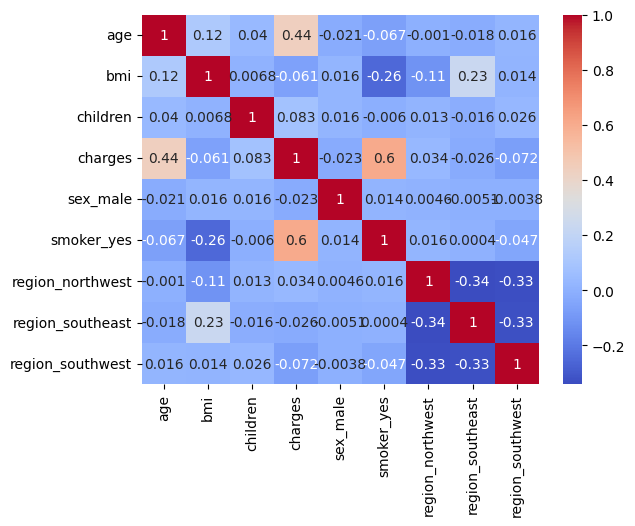

In [11]:
sns.heatmap(df_encode.corr(), annot=True, cmap='coolwarm')

## OLS Model
Train a baseline Linear Regression model to:
- Establish a performance benchmark
- Understand basic relationships


In [12]:
X_ols = sm.add_constant(df_encode.drop('charges', axis=1))
y_ols = df_encode['charges']

ols_model = sm.OLS(y_ols, X_ols).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     226.0
Date:                Wed, 24 Dec 2025   Prob (F-statistic):          3.56e-232
Time:                        14:00:02   Log-Likelihood:                -11744.
No. Observations:                1193   AIC:                         2.351e+04
Df Residuals:                    1184   BIC:                         2.355e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3071.1820    826.381  

### Model Performance

- **R-squared**: 0.604
- **Adj. R-squared**: 0.602

The model explains approximately **60% of the variance** in medical insurance charges, indicating a reasonably strong baseline fit

### Key Findings

- **Age** has a strong and statistically significant positive effect on insurance charges
  *(p < 0.001)*

Older individuals tend to incur higher medical costs.

- **BMI** shows a significant positive relationship with charges
  *(p = 0.002)*

Higher body mass index is associated with increased insurance expenses.

- **Number of children** is also positively associated with charges
  *(p < 0.001)*.

- **Smoking status (`smoker_yes`)** is the most influential predictor:
  - Coef ≈ **14,660**
  - Highly significant *(p < 0.001)*

Smokers pay substantially higher insurance charges compared to non-smokers.

### Interaction Features
Create interaction terms:
- `age_smoker`
- `bmi_smoker`

Hypothesis:
> The effect of age and BMI on insurance charges differs between smokers and non-smokers.


In [16]:
df_interact = df_encode.copy()

df_interact['age_smoker'] = df_interact['age'] * df_interact['smoker_yes']
df_interact['bmi_smoker'] = df_interact['bmi'] * df_interact['smoker_yes']

X_ols2 = sm.add_constant(df_interact.drop('charges', axis=1).astype('float64'))
y_ols2 = df_interact['charges']

ols_model_interact = sm.OLS(y_ols2, X_ols2).fit()

print(ols_model_interact.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     203.8
Date:                Wed, 24 Dec 2025   Prob (F-statistic):          5.20e-249
Time:                        14:01:01   Log-Likelihood:                -11699.
No. Observations:                1193   AIC:                         2.342e+04
Df Residuals:                    1182   BIC:                         2.348e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2107.3408    816.461  

The OLS model is re-run with interaction features to assess potential improvements in explanatory power

Clearly, adding interaction features leads to a substantial improvement in model performance, with R² increasing from 0.604 to 0.633

And some features (`region_northwest`, `sex_male`)  are not statistically significant will be remove from OLS model then will refit OLS model

### Feature Selection & Reduced O Regression Model

Select features based on:
- OLS statistical significance
- Model interpretability
- Domain understanding

Refit Linear Regression using selected features:
- Comparable or improved performance
- Easier interpretation

In [47]:
features = ['age', 'children', 'age_smoker', 'bmi_smoker']

X_ols_reduced = sm.add_constant(df_interact[features].astype("float64"))
y_ols_reduced = df_interact['charges']

ols_reduced = sm.OLS(y_ols_reduced, X_ols_reduced).fit()
print(ols_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     494.2
Date:                Fri, 26 Dec 2025   Prob (F-statistic):          6.50e-251
Time:                        12:44:37   Log-Likelihood:                -11712.
No. Observations:                1193   AIC:                         2.343e+04
Df Residuals:                    1188   BIC:                         2.346e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2476.5935    417.868     -5.927      0.0

After refitting the model, the R² score decreases slightly but remains at a comparable level. However, the refitted model successfully filters out statistically insignificant features, resulting in a more compact and interpretable feature set. This streamlined model provides a solid foundation for the next step: building the Linear Regression model

## Linear Reg

### Train–Test Split
Split the data into:
- 80% training set
- 20% testing set

This ensures unbiased model evaluation


In [27]:
X = df_interact[features].astype("float64")
y = df_interact['charges']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Feature Scaling
Apply **StandardScaler** to numerical features to:
- Improve model convergence
- Make regression coef comparable


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Model Evaluation on Test Set

After training the model, we evaluate its performance on the test set using two common regression metrics:

- R² (Coefficient of Determination): measures how well the model explains the variance in the target variable.

- RMSE (Root Mean Squared Error): captures the average magnitude of prediction errors in the original unit of the target variable.

In [30]:
y_pred = model.predict(X_test_scaled)

print('R2:', r2_score(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred)** 0.5)

R2: 0.6363011359529067
RMSE: 4170.069566372768


### Result

- R²: 0.636
- RMSE: 4,170

These results indicate that the model explains approximately 63.6% of the variance in medical charges, showing a noticeable improvement compared to the baseline model. While some prediction error remains, the performance is reasonable given the linear nature of the model and the complexity of the underlying data.

### Actual vs Predicted Charges

The scatter plot below visualizes the relationship between actual charges and predicted charges on the test set.

- Each point represents an individual observation
- The red dashed line indicates the ideal scenario where predictions perfectly match actual values (y = x).

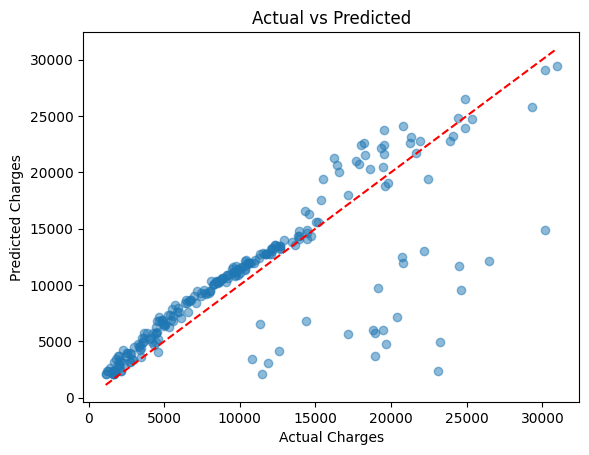

In [32]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')

plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted")

plt.show()


### Summary

The visualization confirms that:

- The model performs well for low to mid-range charges
- Prediction errors increase for higher charge values
- Further improvements may require non-linear models or additional feature engineering

## Key Insights

Medical charges are primarily driven by smoking behavior, with age and BMI acting as risk multipliers rather than independent cost factors.

- Smoking status is the most influential factor affecting medical charges, contributing significantly higher costs compared to non-smokers
- Age and BMI have a strong positive relationship with insurance charges, consistent with real-world healthcare trends
- Adding interaction features improves model performance, increasing R² from 0.604 to 0.633, indicating non-additive effects between variables
- Feature selection slightly reduces R² but improves interpretability, resulting in a cleaner and more explainable model
- Linear regression performs well for low to mid-range charges, but struggles with extreme high-cost cases, suggesting room for non-linear models.